# 2D Geometric Tranformation

In [42]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os

In [43]:
# Obtener una grilla para realizar las transformaciones

def get_grid(height, width, homogenous=False):
    coords = np.indices((height, width)).reshape(2, -1) 
    # Get indices of matrix (x, y)
    # [r1, r2, r3]
    # [c1, c2, c3]

    return np.vstack((coords, np.ones(coords.shape[1]))).astype(np.int32) if homogenous else coords
    # Get indices of matrix (x, y, 1)
    # [r1, r2, r3]
    # [c1, c2, c3]
    # [ 1,  1,  1]

In [44]:
# Imprime la imágen

def show_image(img):
    fig, ax = plt.subplots(figsize=(8,6))
    ax.imshow(img)
    plt.show()

In [45]:
# Obtiene una matriz de transformación (o combinación de transformaciones)
# trasladar al centro -> rotar -> scalar/invertir -> volver a su posición

def get_transformed_matrix(angle, rot, tx, ty, sx, sy):
    R = np.array([
        [np.cos(angle), np.sin(angle), 0],
        [-np.sin(angle), np.cos(angle), 0],
        [0, 0, 1]
    ])

    T = np.array([
        [1, 0, tx],
        [0, 1, ty],
        [0, 0, 1]
    ])

    if rot % 180 == 0:
        T2 = np.array([
            [1, 0, tx],
            [0, 1, ty],
            [0, 0, 1]
        ])
    else:
        T2 = np.array([
            [1, 0, ty],
            [0, 1, tx],
            [0, 0, 1]
        ])

    S = np.array([
        [sx, 0, 0],
        [0, sy, 0],
        [0, 0, 1]
    ])

    A = T2@R@S@np.linalg.inv(T)
    return A

In [46]:
# obtener una imágen, rotado (rot) y con reflexión (sx eje 'x'), (sy eje 'y')

def get_based_on_rotation(img, rot, sx, sy):
    height, width = img.shape[:2]
    tx, ty = np.array((height//2, width//2))

    angle = np.radians(rot)
    A = get_transformed_matrix(angle, rot, tx, ty, sx, sy)
    
    # Grid to represent the image coordinates I (x, y)
    coords = get_grid(height, width, True)
    x1, y1 = coords[0], coords[1]

    # Apply transformation and nearest neighbor interpolation
    warp_coords = np.round(A @ coords).astype(np.int32)
    x2, y2 = warp_coords[0, :], warp_coords[1, :]

    # Get pixels within image
    if rot % 180 == 0:
        indices = np.where((x2 >= 0) & (x2 < height) &
                        (y2 >= 0) & (y2 < width))
    else:
        indices = np.where((x2 >= 0) & (x2 < width) &
                        (y2 >= 0) & (y2 < height))

    xpix2, ypix2 = x2[indices], y2[indices]
    xpix1, ypix1 = x1[indices], y1[indices]

    # Copy the values to new image I'(x, y)
    if rot % 180 == 0:
        canvas = np.zeros((height, width, 3))
    else:
        canvas = np.zeros((width, height, 3))
        
    canvas = canvas.astype(int)
    canvas[xpix2, ypix2] = img[xpix1, ypix1]
    #show_image(canvas)
    return canvas

In [47]:
# Imprimir el area formado por los puntos con o sin la imágen

def print_points_image(source, target, title='', img=None):
    fig, ax = plt.subplots(figsize=(8,6))

    if img is not None:
        ax.imshow(img)
    
    x, y = source[1], source[0]
    #ax.scatter(x, y, label='source', marker='o', alpha=0.8, s=200, c='r')
    
    x, y = target[1], target[0]
    #ax.scatter(x, y, label='target', marker='x', alpha=0.8, s=300, c='y')
    ax.fill(x, y, label='target', alpha=0.5, c='r')

    
    ax.legend()
    # ax.set_xlim(-10, 650)
    # ax.set_ylim(-10, 550)
    ax.invert_yaxis()
    ax.grid(True)
    ax.set_title(title)
    plt.show()

In [48]:
# Imprimir el area formado por los puntos con o sin la imágen

def print_points_image_v2(pts, title='', img=None):
    fig, ax = plt.subplots(figsize=(8,6))

    if img is not None:
        ax.imshow(img)
    
    for i in range(0, len(pts[0]), 4):
        x, y = pts[1][i:i+4], pts[0][i:i+4]
        x = np.append(x, x[0])
        y = np.append(y, y[0])
        #ax.scatter(x, y, label='target', marker='x', alpha=0.8, s=300, c='y')
        ax.plot(x, y)

    
    # ax.legend()
    # ax.set_xlim(-10, 650)
    # ax.set_ylim(-10, 550)
    ax.invert_yaxis()
    ax.set_title(title)
    plt.show()

In [49]:
# Escribir en un archivo las nuevas coordenadas

def write_points(path, pts):
    with open(path, 'w') as f:
        for i in range(0, len(pts[0]), 4):
            x, y = pts[1][i:i+4], pts[0][i:i+4]
            x1 = x[0]
            y1 = y[0]
            x2 = x[2]
            y2 = y[2]
            print('1'+' '+str(x1)+' '+str(y1)+' '+str(x2)+' '+str(y2)+'\n')
            f.write('1'+' '+str(x1)+' '+str(y1)+' '+str(x2)+' '+str(y2)+'\n')
    f.close()

In [50]:
# Transformar los puntos + transformar la imágen 
# resultado puntos (wrap_coords)
# resultado imágen (auximg)

def transformed_pts(img, pts, name):
    height, width = img.shape[:2]
    tx, ty = np.array((height//2, width//2))
    rotations = [0, 90, 180, 270]

    for rot in rotations:
        angle = np.radians(rot)
        A = get_transformed_matrix(angle, rot, tx, ty, sx=1, sy=1)
        warp_coords = np.round(A@pts).astype(np.int32)
        #print(pts)
        #print('rot'+str(rot), ':', warp_coords)
        auximg = get_based_on_rotation(img, rot, sx=1, sy=1)
        cv2.imwrite('./output/'+name+'_rot'+str(rot)+'.png', auximg)
        print_points_image_v2(warp_coords, name+'rot'+str(rot), auximg)
        write_points('./output/'+name+'_rot'+str(rot)+'.txt', warp_coords)
    
    # Changint the source (just for plot)
    A = get_transformed_matrix(0, 0, tx, ty, sx=-1, sy=1)
    auxpts = np.round(A@pts).astype(np.int32)

    for rot in rotations:
        angle = np.radians(rot)
        A = get_transformed_matrix(angle, rot, tx, ty, sx=-1, sy=1)
        warp_coords = np.round(A@pts).astype(np.int32)
        #print(auxpts)
        #print('reflex+rot'+str(rot), ':', warp_coords)
        auximg = get_based_on_rotation(img, rot, sx=-1, sy=1)
        cv2.imwrite('./output/'+name+'_reflex+rot'+str(rot)+'.png', auximg)
        print_points_image_v2(warp_coords, name+'reflex+rot'+str(rot), auximg)
        write_points('./output/'+name+'_reflex+rot'+str(rot)+'.txt', warp_coords)

./test/20220919_125231_jpg.rf.c57d68a1503d9f0b5918397f69fa8419.jpg


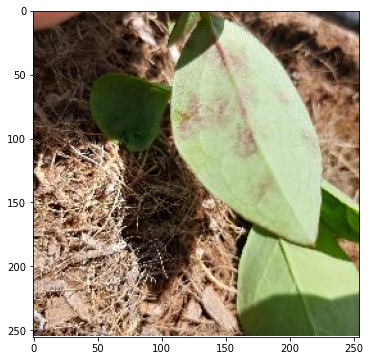

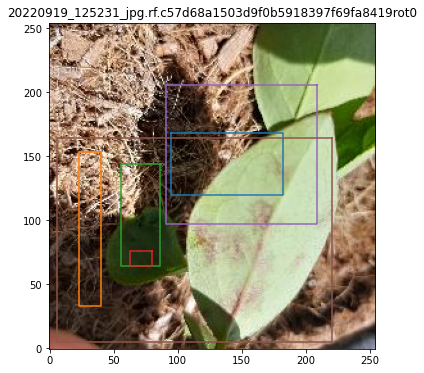

1 95 168 182 120

1 40 153 23 33

1 86 144 56 64

1 80 76 63 64

1 209 206 91 97

1 221 164 6 5



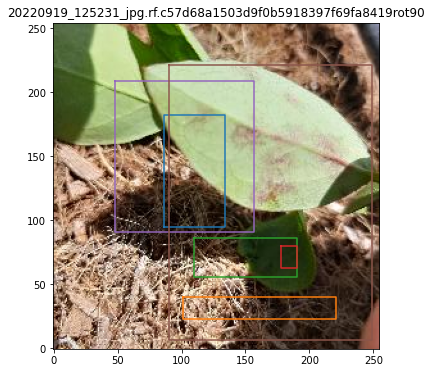

1 86 95 134 182

1 101 40 221 23

1 110 86 190 56

1 178 80 190 63

1 48 209 157 91

1 90 221 249 6



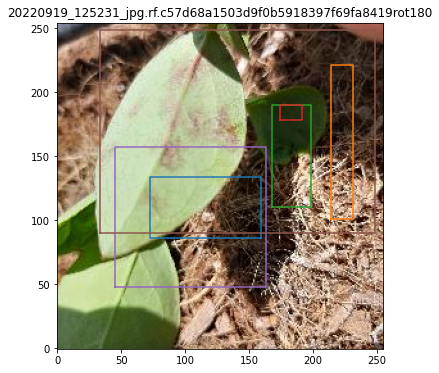

1 159 86 72 134

1 214 101 231 221

1 168 110 198 190

1 174 178 191 190

1 45 48 163 157

1 33 90 248 249



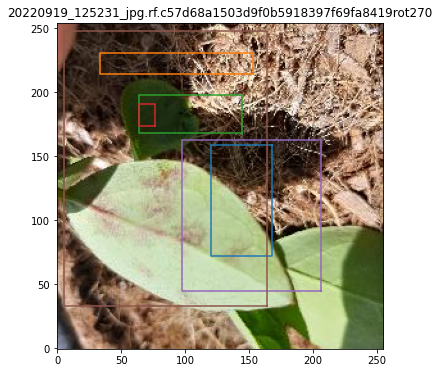

1 168 159 120 72

1 153 214 33 231

1 144 168 64 198

1 76 174 64 191

1 206 45 97 163

1 164 33 5 248



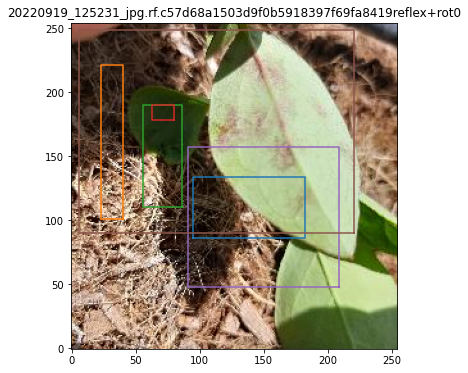

1 95 86 182 134

1 40 101 23 221

1 86 110 56 190

1 80 178 63 190

1 209 48 91 157

1 221 90 6 249



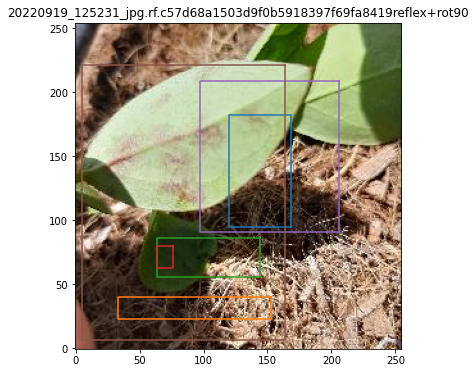

1 168 95 120 182

1 153 40 33 23

1 144 86 64 56

1 76 80 64 63

1 206 209 97 91

1 164 221 5 6



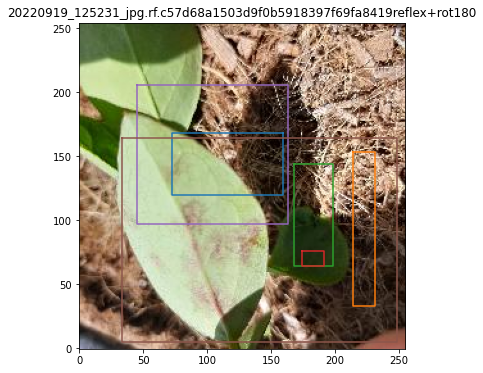

1 159 168 72 120

1 214 153 231 33

1 168 144 198 64

1 174 76 191 64

1 45 206 163 97

1 33 164 248 5



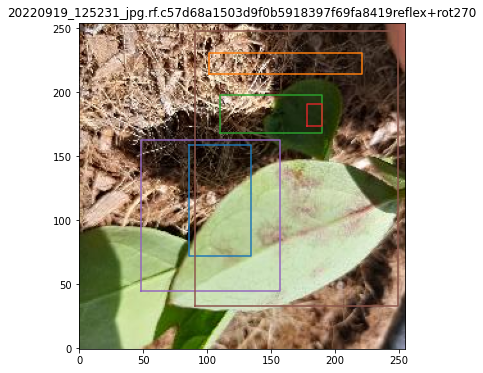

1 86 159 134 72

1 101 214 221 231

1 110 168 190 198

1 178 174 190 191

1 48 45 157 163

1 90 33 249 248

./test/20220919_144201_jpg.rf.a5fcb664899027aa2c4f1ddba43848f4.jpg


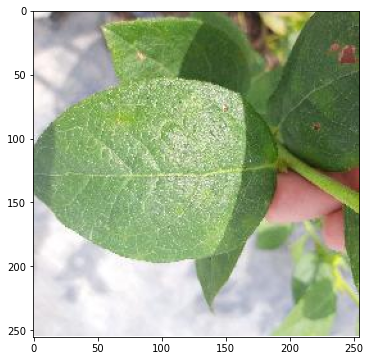

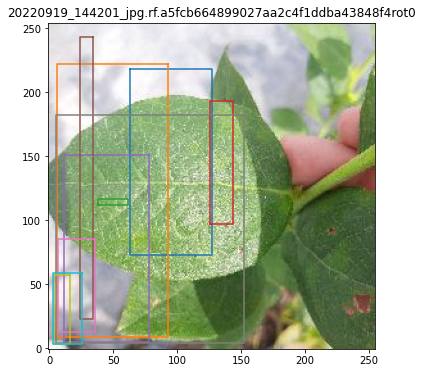

1 63 218 127 73

1 93 222 6 9

1 38 112 62 117

1 126 97 144 193

1 78 151 12 5

1 34 243 24 23

1 36 85 7 13

1 152 182 5 4

1 16 57 4 3

1 26 59 3 3



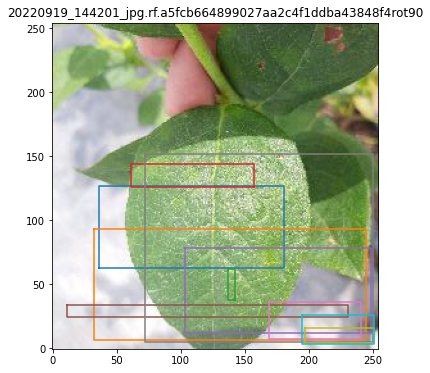

1 36 63 181 127

1 32 93 245 6

1 142 38 137 62

1 157 126 61 144

1 103 78 249 12

1 11 34 231 24

1 169 36 241 7

1 72 152 250 5

1 197 16 251 4

1 195 26 251 3



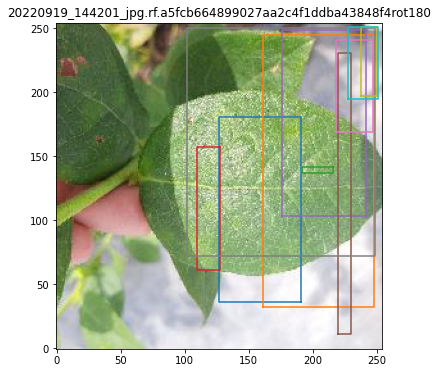

1 191 36 127 181

1 161 32 248 245

1 216 142 192 137

1 128 157 110 61

1 176 103 242 249

1 220 11 230 231

1 218 169 247 241

1 102 72 249 250

1 238 197 250 251

1 228 195 251 251



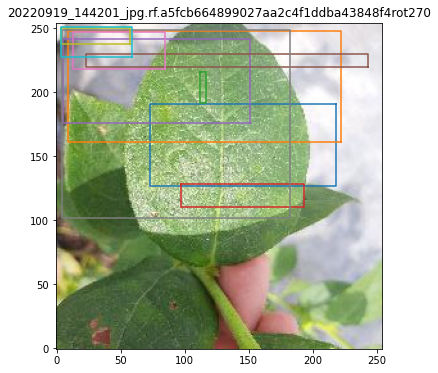

1 218 191 73 127

1 222 161 9 248

1 112 216 117 192

1 97 128 193 110

1 151 176 5 242

1 243 220 23 230

1 85 218 13 247

1 182 102 4 249

1 57 238 3 250

1 59 228 3 251



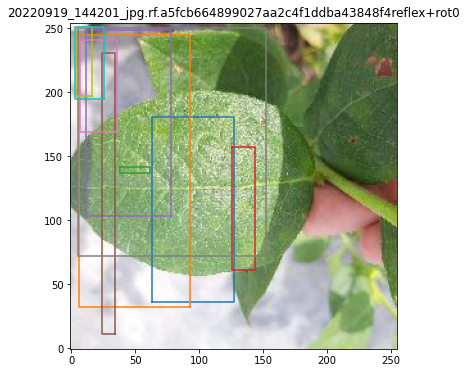

1 63 36 127 181

1 93 32 6 245

1 38 142 62 137

1 126 157 144 61

1 78 103 12 249

1 34 11 24 231

1 36 169 7 241

1 152 72 5 250

1 16 197 4 251

1 26 195 3 251



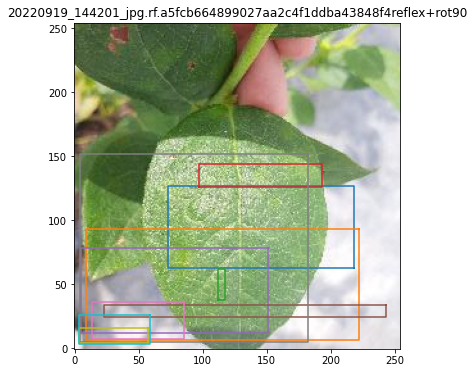

1 218 63 73 127

1 222 93 9 6

1 112 38 117 62

1 97 126 193 144

1 151 78 5 12

1 243 34 23 24

1 85 36 13 7

1 182 152 4 5

1 57 16 3 4

1 59 26 3 3



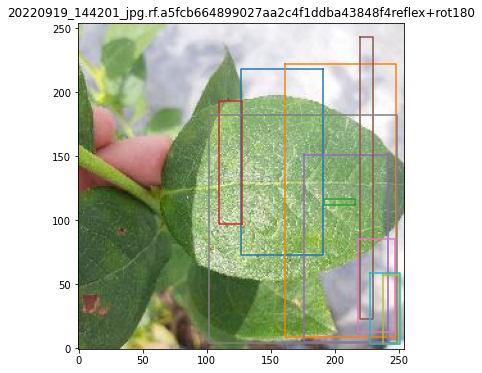

1 191 218 127 73

1 161 222 248 9

1 216 112 192 117

1 128 97 110 193

1 176 151 242 5

1 220 243 230 23

1 218 85 247 13

1 102 182 249 4

1 238 57 250 3

1 228 59 251 3



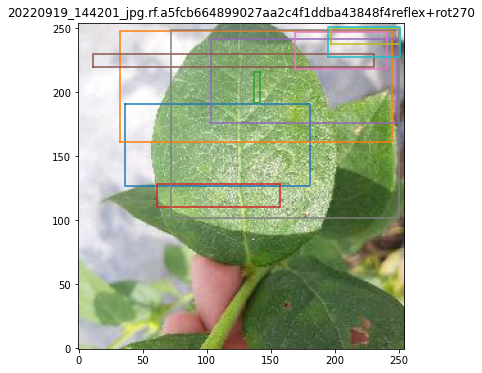

1 36 191 181 127

1 32 161 245 248

1 142 216 137 192

1 157 128 61 110

1 103 176 249 242

1 11 220 231 230

1 169 218 241 247

1 72 102 250 249

1 197 238 251 250

1 195 228 251 251



In [51]:
# Main
# Mostrar la imágen original y proceder con la transformación

with os.scandir('test/') as entries:
    for entry in entries:
        filename = entry.name
        if filename[-4:] == '.txt':
            name = filename[:-4]
            image_path = './test/{}.jpg'.format(name)

            print(image_path)
            image = cv2.imread(image_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            height, width = image.shape[:2]

            fig, ax = plt.subplots(figsize=(8, 6))
            ax.imshow(image)

            pts = [[], [], []]

            with open('./test/{}.txt'.format(name), 'r') as f:
                line = f.readline()
                while line != '': 
                    line = line.strip()
                    line = list(line.split())
                    line = [float(val) for val in line]
                    x1 = int(line[1]*width)
                    y1 = int(line[2]*height)
                    x2 = int(line[3]*width)
                    y2 = int(line[4]*height)
                    pts[0].extend([x1, x1, x2, x2])
                    pts[1].extend([y1, y2, y2, y1])
                    pts[2].extend([1, 1, 1, 1])


                    # ax.fill([x1, x1, x2, x2], [y1, y2, y2, y1], label='origin', alpha=0.8)

                    # pts[0].append(line[0]) 
                    # pts[1].append(line[1])
                    # pts[2].append(1) 
                    line = f.readline()
                f.close()

            #ax.scatter(pts[1], pts[0], label='origin', marker='o', alpha=0.8, s=100, c='r')
            

            #ax.set_xlim(-10, 650)
            ax.set_ylim(0, image.shape[0])
            ax.invert_yaxis()
            plt.show()
            transformed_pts(image, pts, name)

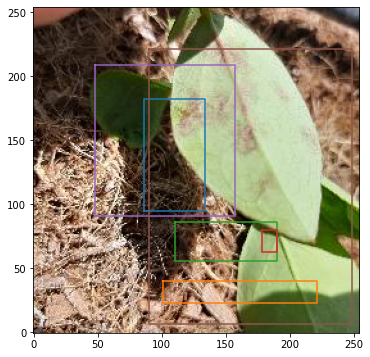

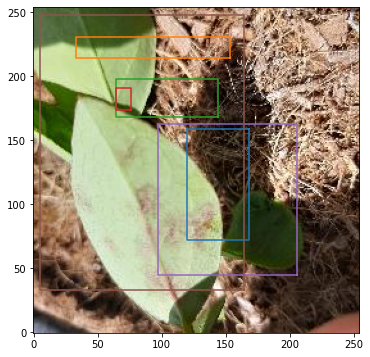

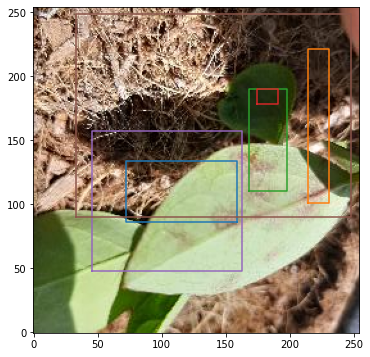

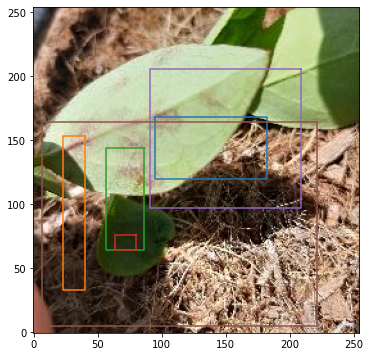

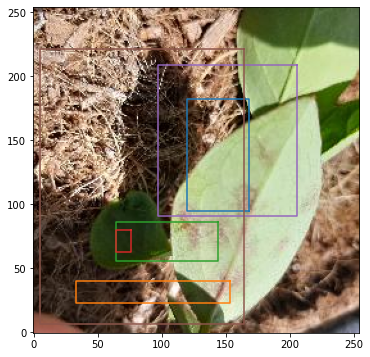

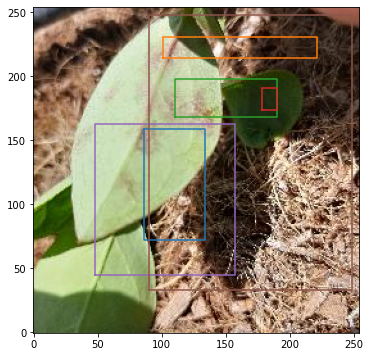

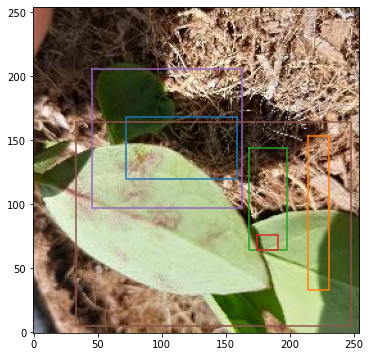

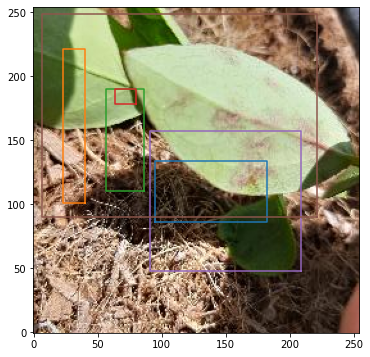

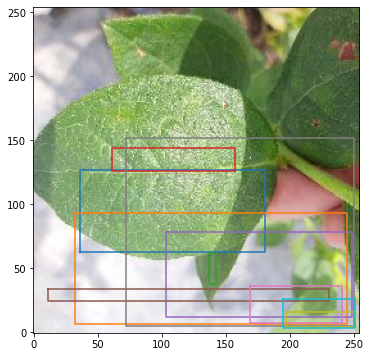

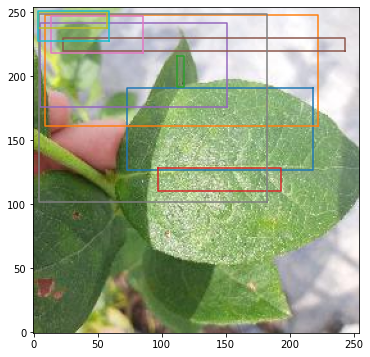

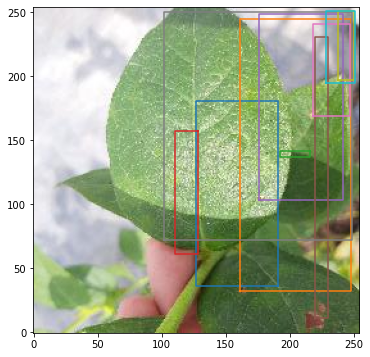

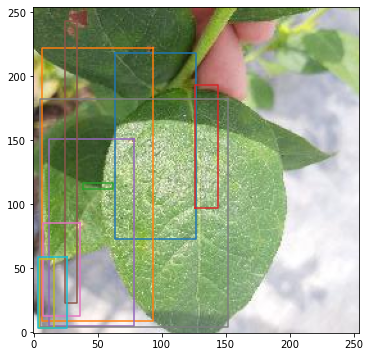

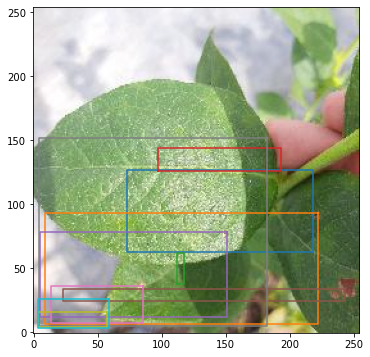

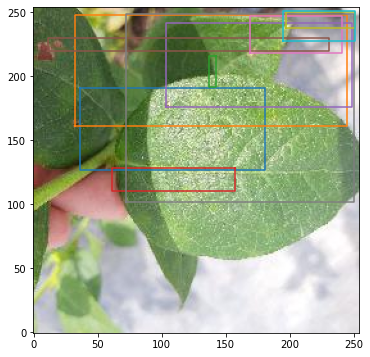

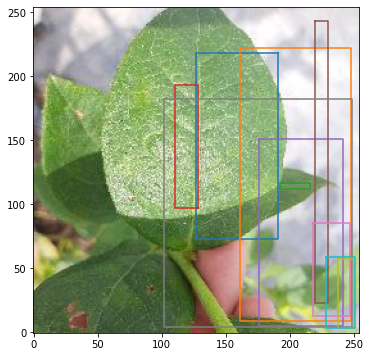

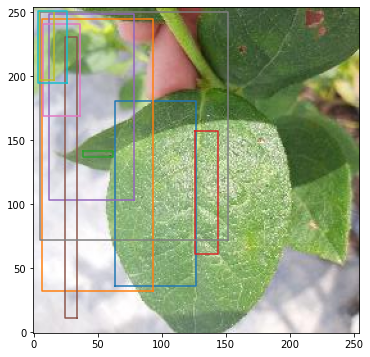

In [52]:
# Prueba para leer los puntos y la imágen, luego imprimirlos

with os.scandir('output/') as entries:
    for entry in entries:
        filename = entry.name
        if filename[-4:] == '.txt':
            name = filename[:-4]
            image_path = './output/{}.png'.format(name)

            # print(image_path)
            image = cv2.imread(image_path)
            #fig, ax = plt.subplots(figsize=(8, 6))
            height, width = image.shape[:2]
            # ax.imshow(image)

            pts = [[], [], []]

            with open('./output/{}.txt'.format(name), 'r') as f:
                line = f.readline()
                while line != '': 
                    line = line.strip()
                    line = list(line.split())
                    line = [float(val) for val in line]
                    x1 = int(line[1])
                    y1 = int(line[2])
                    x2 = int(line[3])
                    y2 = int(line[4])
                    pts[0].extend([x1, x1, x2, x2])
                    pts[1].extend([y1, y2, y2, y1])
                    pts[2].extend([1, 1, 1, 1])

                    line = f.readline()

                f.close()

            #ax.scatter(pts[1], pts[0], label='origin', marker='o', alpha=0.8, s=100, c='r')
            # ax.fill(pts[1], pts[0], label='origin', alpha=0.5, c='b')

            #ax.set_xlim(-10, 650)
            # ax.set_ylim(0, image.shape[0])
            # ax.invert_yaxis()
            # plt.show()
            print_points_image_v2(pts, '', image)